# Introduction to the basics of RL algorithms

This notebook introduces some basic algorithms, before digging to more serious implementation using GPU-enabled simulators and baseline solver implementation in a second notebook.

## Setup

We will need Torch for the neural implementation, Gymnasium for the example scenarios and CleanRL for algorithms implementation, although we are mostly going to use the dependancies of CleanRL.

In [2]:
!pip install cleanrl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.1 MB/s eta 0:00:00
  

We are not going to spend a lot of time looking at these environments, but still, it would be nice to display them. Not so easy, but here is a trick.

In [17]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
Display().start()

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


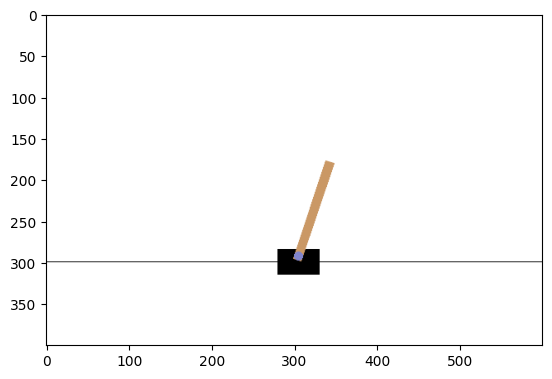

In [26]:
import gymnasium as gym
env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()

# Configure the renderer
img = plt.imshow(env.render()) # only call this once

for _ in range(40):
    # Play the game
    action = env.action_space.sample()
    env.step(action)

    # Then render
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)


## Starting simple with a Q-Table

We first focus on a full-discrete environment, which allows to work with a Q-table.


### Code of the environment (execute but don't read it)

In [27]:
import numpy as np
import gymnasium as gym

class EnvMountainCarFullyDiscrete(gym.Wrapper):
    def __init__(self, n_bins=(51, 51),**kwargs):
        env = gym.make("MountainCar-v0",**kwargs).unwrapped
        super().__init__(env)
        self.n_bins = n_bins

        # Définition des bornes des états
        self.state_bounds = [
            [-1.2, 0.6],   # Position du chariot
            [-0.1, .1],   # Vitesse du chariot
       ]

        # Création des bins pour discrétiser l'état
        self.bins = [np.linspace(low-1e-6, high+1e-6, num=n, endpoint=True)
                     for (low, high), n in zip(self.state_bounds, self.n_bins)]
        # Basis value for representing the bin indexes as a single integer
        self.bin_base = [ int(np.prod(self.n_bins[:n])) for n in range(len(self.n_bins)) ]

        # Définition de l'espace d'observation discret
        #self.observation_space = gym.spaces.MultiDiscrete(self.n_bins)
        self.observation_space = gym.spaces.Discrete(np.prod(self.n_bins))

    def discrete_state_to_index(self,bins):
        return sum([ idx*base for (idx,base) in zip(bins,self.bin_base) ])
    def index_to_discrete_state(self,index):
        bins = []
        for n in self.n_bins:
            bins.append(index%n)
            index = index // n
        return bins

    def discretize_state(self, state):
        """Convertit un état continu en un index discret."""
        return [np.digitize(s, bins) for s, bins in zip(state, self.bins)]

    def undiscretize_state(self, discrete_state):
        """Transforme un état discret en état continu en prenant le centre du bin."""
        assert self.is_discrete_state_in_range(discrete_state)
        return np.array([
            (self.bins[i][d-1] + self.bins[i][d]) / 2 if 0 < d < len(self.bins[i]) else self.state_bounds[i][d == 0]
            for i, d in enumerate(discrete_state)
        ])

    def is_discrete_state_in_range(self,discrete_state):
        """Check that non of the bins is out of the state space"""
        res = 0 not in discrete_state
        res = res and  np.all([ d<n for d,n in zip(discrete_state,self.n_bins) ])
        return res

    def is_index_in_range(self,index):
        if index<0 or index>self.observation_space.n: return False
        return self.is_discrete_state_in_range(self.index_to_discrete_state(index))

    def step(self, action):
        """Exécute une action et retourne l'état sous forme discrète."""
        # Step 10 times in the continuous space to ensure enough movements
        # to pass a discrete bin.
        for i in range(10):
            next_state_cont, reward, done, trunc, info = self.env.step(action)
            if done: break
        next_state_discrete = self.discretize_state(next_state_cont)
        if not self.is_discrete_state_in_range(next_state_discrete):
            done = False
            trunc = True
            self.state = None
        else:
            # Reconvertir en état continu pour rester dans un espace propre
            self.env.state = self.undiscretize_state(next_state_discrete)
            self.discrete_state = next_state_discrete
            self.state = self.discrete_state_to_index(next_state_discrete)
        return self.state, reward, done, trunc, info

    def reset(self, **kwargs):
        """Réinitialise l'environnement avec un état strictement discret."""
        continuous_state, info = self.env.reset(**kwargs)
        self.discrete_state = self.discretize_state(continuous_state)
        assert self.is_discrete_state_in_range(self.discrete_state)
        self.state = self.discrete_state_to_index(self.discrete_state)
        # On force le reset sur un état discretisé
        self.env.state = self.undiscretize_state(self.discrete_state)
        return self.state,info



### Environment usage
You can play with it:

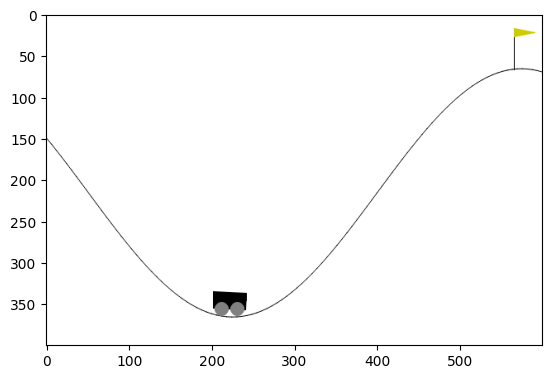

In [30]:
env = EnvMountainCarFullyDiscrete(render_mode='rgb_array')
env.reset()

# Configure the renderer
img = plt.imshow(env.render())

for _ in range(40):
    # Play the game
    action = env.action_space.sample()
    env.step(action)

    # Then render
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)



### Q-Table algorithm

The algorithm represent the Q value as a simple table Q(x,u). The policy is an argmax on the possible u values: policy(x) = argmax(Q[x,:]). The optimization is done by applying the Belman operator.


In [31]:
### --- Random seed
RANDOM_SEED = 1188  # int((time.time()%10)*1000)
print("Seed = %d" % RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### --- Environment
env = EnvMountainCarFullyDiscrete()

### --- Hyper paramaters
NEPISODES = 40000  # Number of training episodes
NSTEPS = 50  # Max episode length
LEARNING_RATE = 0.85  #
DECAY_RATE = 0.99  # Discount factor

assert isinstance(env.observation_space,gym.spaces.discrete.Discrete)
assert isinstance(env.action_space,gym.spaces.discrete.Discrete)
Q = np.zeros([env.observation_space.n, env.action_space.n])  # Q-table initialized to 0

h_rwd = []  # Learning history (for plot).
for episode in range(1, NEPISODES):
    x,_ = env.reset()
    rsum = 0.0
    for steps in range(NSTEPS):
        u = np.argmax(
            Q[x, :] + np.random.randn(1, env.action_space.n) / episode
        )  # Greedy action with noise
        x2, reward, done, trunc, info = env.step(u)

        # Compute reference Q-value at state x respecting HJB
        Qref = reward + DECAY_RATE * np.max(Q[x2, :])

        # Update Q-Table to better fit HJB
        Q[x, u] += LEARNING_RATE * (Qref - Q[x, u])
        x = x2
        rsum += reward
        if done or trunc: break

    h_rwd.append(rsum)
    if not episode % 20:
        print(
            "Episode #%d done with average cost %.2f" % (episode, sum(h_rwd[-20:]) / 20)
        )


Seed = 1188
Episode #20 done with average cost -43.95
Episode #40 done with average cost -46.50
Episode #60 done with average cost -40.20
Episode #80 done with average cost -40.85
Episode #100 done with average cost -44.65
Episode #120 done with average cost -38.50
Episode #140 done with average cost -38.65
Episode #160 done with average cost -38.10
Episode #180 done with average cost -35.85
Episode #200 done with average cost -31.55
Episode #220 done with average cost -31.05
Episode #240 done with average cost -29.55
Episode #260 done with average cost -29.30
Episode #280 done with average cost -31.40
Episode #300 done with average cost -33.55
Episode #320 done with average cost -27.85
Episode #340 done with average cost -26.10
Episode #360 done with average cost -28.85
Episode #380 done with average cost -30.40
Episode #400 done with average cost -28.35
Episode #420 done with average cost -24.15
Episode #440 done with average cost -27.50
Episode #460 done with average cost -24.30
Epi

KeyboardInterrupt: 

We can plot some results.

First, the learning curve, showing cumulative rewards accross episods.

Total rate of success: -2.475


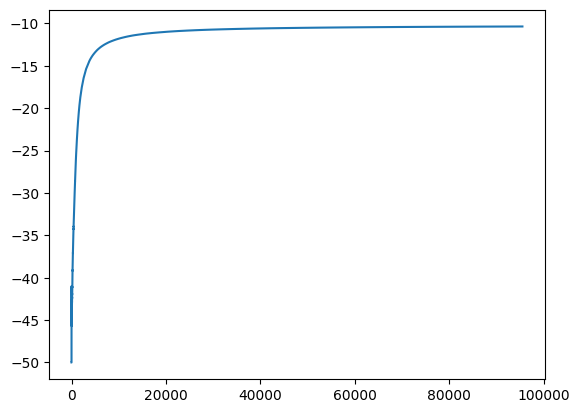

In [32]:

# ### Plot the learning curve
print("Total rate of success: %.3f" % (sum(h_rwd) / NEPISODES))
plt.plot(np.cumsum(h_rwd) / range(1, len(h_rwd)+1))


Then, let's rollout an episod of the resulting policy.

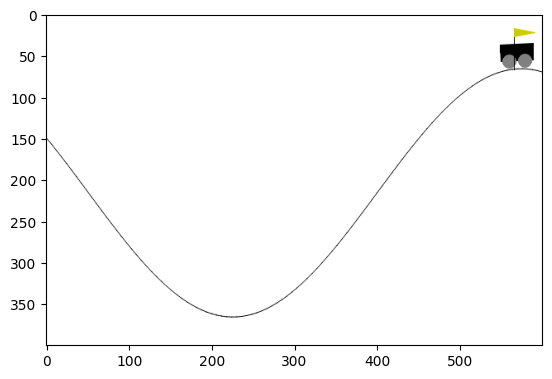

In [41]:

envrender = EnvMountainCarFullyDiscrete(render_mode = 'rgb_array')
s,_ = envrender.reset()
traj = [s]
img = plt.imshow(envrender.render()) # only call this once
for i in range(100):
    a = np.argmax(Q[s, :])
    s, r, done, trunc, info = envrender.step(a)
    traj.append(s)

    img.set_data(envrender.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done: break

Finally, the value function. We display it as a color map along position and velocity of the car.

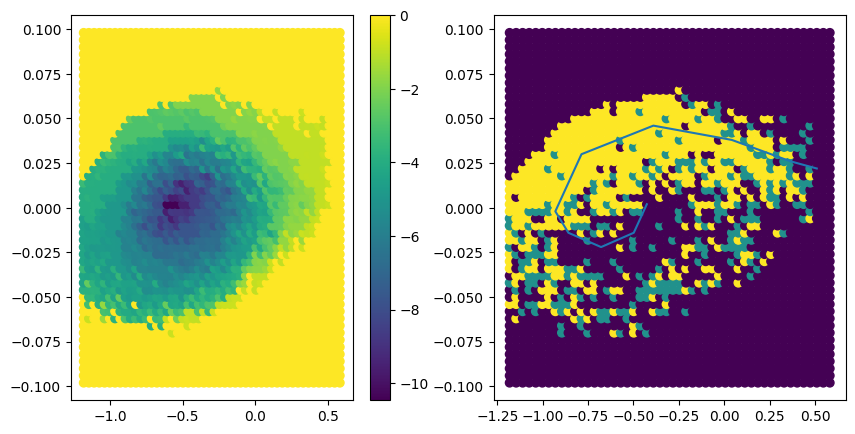

In [42]:
# ### Plot Q-Table as value function pos-vs-vel
def indexes_to_continuous_states(indexes):
    return [ env.undiscretize_state(env.index_to_discrete_state(s))
             for s in indexes if env.is_index_in_range(s) ]


fig,axs = plt.subplots(1,2,figsize=(10,5))
qvs = indexes_to_continuous_states(range(env.observation_space.n))
values = [ np.max(Q[s,:]) for s in range(env.observation_space.n)
           if env.is_index_in_range(s) ]
vplot = axs[0].scatter([qv[0] for qv in qvs],[qv[1] for qv in qvs],c=values)
plt.colorbar(vplot,ax=axs[0])
policies = [ np.argmax(Q[s,:]) for s in range(env.observation_space.n)
           if env.is_index_in_range(s) ]
axs[1].scatter([qv[0] for qv in qvs],[qv[1] for qv in qvs],c=policies)


qv_traj = indexes_to_continuous_states(traj)
plt.plot([qv[0] for qv in qv_traj],[qv[1] for qv in qv_traj],'-')



## Making the table deep

Next, we redo the same but considering the table as a simplistic neural network, and enforcing the Belman recursion through gradient descent. Much less efficient, but opens the door to deeper representation.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QValueNetwork(nn.Module):
    def __init__(self, env, learning_rate=LEARNING_RATE):
        assert isinstance(env.observation_space,gym.spaces.discrete.Discrete)
        assert isinstance(env.action_space,gym.spaces.discrete.Discrete)

        super(QValueNetwork, self).__init__()

        # Linear layer from input size NX to output size NU
        self.fc = nn.Linear(env.observation_space.n,env.action_space.n)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        qvalue = self.fc(x)
        return qvalue

    def predict_action(self, x, noise=0):
        qvalue = self.forward(x)
        if noise != 0:
            qvalue += torch.randn(qvalue.shape) * noise
        u = torch.argmax(qvalue,dim=1)
        return u

    def update(self, x, qref):
        self.optimizer.zero_grad()
        qvalue = self.forward(x)
        loss = F.mse_loss(qvalue, qref)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def plot(self):

        # ### Plot Q-Table as value function pos-vs-vel
        def indexes_to_continuous_states(indexes):
            return [ env.undiscretize_state(env.index_to_discrete_state(s))
                     for s in indexes if env.is_index_in_range(s) ]
        Q = self.fc.weight.T
        fig,axs = plt.subplots(1,2,figsize=(10,5))
        qvs = indexes_to_continuous_states(range(env.observation_space.n))
        values = [ float(torch.max(Q[s,:])) for s in range(env.observation_space.n)
                   if env.is_index_in_range(s) ]
        vplot = axs[0].scatter([qv[0] for qv in qvs],[qv[1] for qv in qvs],c=values)
        plt.colorbar(vplot,ax=axs[0])
        policies = [ int(torch.argmax(Q[s,:])) for s in range(env.observation_space.n)
                     if env.is_index_in_range(s) ]
        axs[1].scatter([qv[0] for qv in qvs],[qv[1] for qv in qvs],c=policies)




qvalue = QValueNetwork(env)

def one_hot(ix, env):
    """Return a one-hot encoded tensor.

    - ix: index or batch of indices
    - n: number of classes (size of the one-hot vector)
    """
    ix = torch.tensor(ix).long()
    if ix.dim() == 0:  # If a single index, add batch dimension
        ix = ix.unsqueeze(0)
    return F.one_hot(ix,num_classes=env.observation_space.n).to(torch.float32)

### --- History of search
h_rwd = []  # Learning history (for plot).

### --- Training
for episode in range(1, NEPISODES):
    x, _ = env.reset()
    rsum = 0.0

    for step in range(NSTEPS - 1):

        u = int(qvalue.predict_action(one_hot(x,env),noise=1/episode))  # ... with noise
        x2, reward, done, trunc, info = env.step(u)

        # Compute reference Q-value at state x respecting HJB
        # Q2 = sess.run(qvalue.qvalue, feed_dict={qvalue.x: onhot(x2)})
        qnext = qvalue(one_hot(x2,env))
        qref = qvalue(one_hot(x,env))
        qref[0, u] = reward + DECAY_RATE * torch.max(qnext)

        # Update Q-table to better fit HJB
        #sess.run(qvalue.optim, feed_dict={qvalue.x: onehot(x), qvalue.qref: Qref})
        qvalue.update(x=one_hot(x,env),qref=qref)

        rsum += reward
        x = x2
        if done or trunc: break

    h_rwd.append(rsum)
    if not episode % 20:
        print("Episode #%d done with %d sucess" % (episode, sum(h_rwd[-20:])))


<>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-44-d7784eea2a3e>:22: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if noise is not 0:


Episode #20 done with -968 sucess
Episode #40 done with -980 sucess
Episode #60 done with -980 sucess
Episode #80 done with -980 sucess
Episode #100 done with -980 sucess
Episode #120 done with -980 sucess
Episode #140 done with -980 sucess
Episode #160 done with -980 sucess
Episode #180 done with -980 sucess
Episode #200 done with -980 sucess
Episode #220 done with -980 sucess
Episode #240 done with -980 sucess
Episode #260 done with -980 sucess
Episode #280 done with -980 sucess
Episode #300 done with -980 sucess
Episode #320 done with -935 sucess
Episode #340 done with -980 sucess
Episode #360 done with -980 sucess
Episode #380 done with -980 sucess
Episode #400 done with -980 sucess
Episode #420 done with -980 sucess
Episode #440 done with -980 sucess
Episode #460 done with -956 sucess
Episode #480 done with -950 sucess
Episode #500 done with -980 sucess
Episode #520 done with -980 sucess
Episode #540 done with -959 sucess
Episode #560 done with -980 sucess
Episode #580 done with -

KeyboardInterrupt: 

Similarly, we can plot the results.

Total rate of success: -0.250


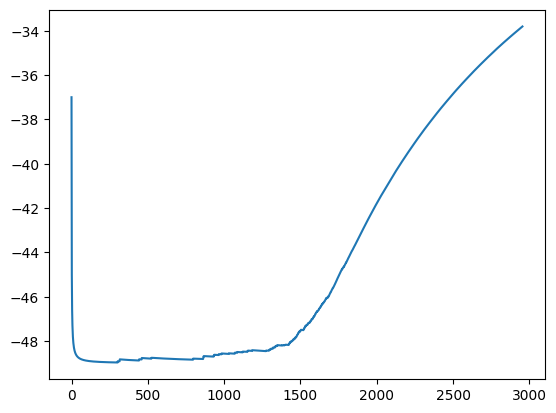

In [45]:
print("Total rate of success: %.3f" % (sum(h_rwd) / NEPISODES))
plt.plot(np.cumsum(h_rwd) / range(1, len(h_rwd)+1))

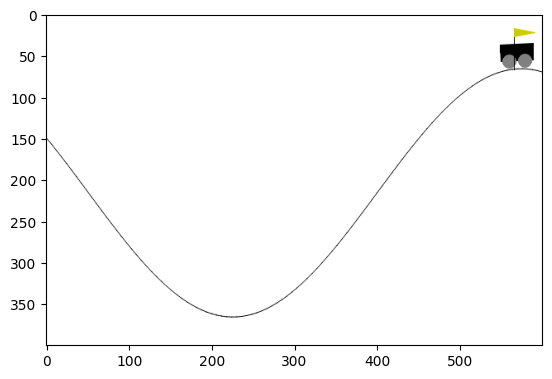

In [46]:

envrender = EnvMountainCarFullyDiscrete(render_mode = 'rgb_array')
s,_ = envrender.reset()
traj = [s]
img = plt.imshow(envrender.render()) # only call this once
for i in range(100):
    a = int(qvalue.predict_action(one_hot(s,env)))
    s, r, done, trunc, info = envrender.step(a)
    traj.append(s)

    img.set_data(envrender.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done: break

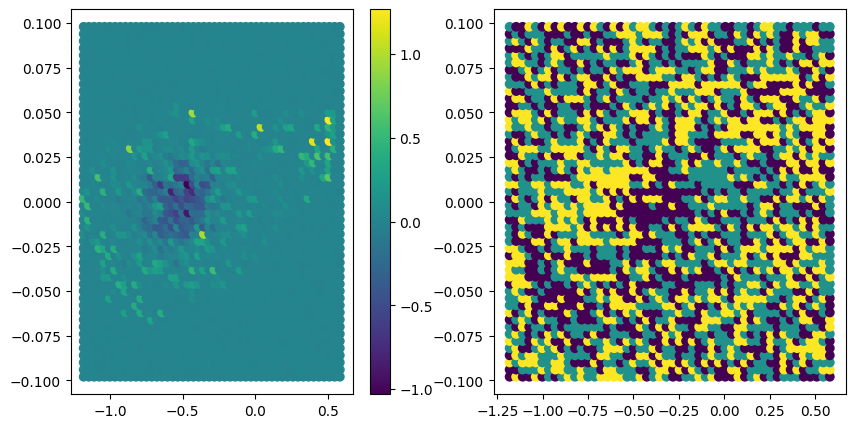

In [47]:
qvalue.plot()

## DQN

Now that we can accept a neural representation of the Q function, any inputs can be taken. Let's switch to a continuous state. For now, we will keep the argmax policy decision, meaning we need to stay in an environment with discrete policy.

In [79]:
import random
from stable_baselines3.common.buffers import ReplayBuffer

# HYPERPARAM
SEED = 1
ENV_ID = "CartPole-v1"
NUM_ENVS = 1
LEARNING_RATE = 0.00025
BUFFER_SIZE = 10000
TOTAL_TIMESTEPS = 500000
TRAIN_FREQUENCY = 10
BATCH_SIZE = 128
GAMMA = 0.99
TARGET_NETWORK_FREQUENCY = 500
TAU = 1.0

# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

# TRY NOT TO MODIFY: seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# env setup
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk

envs = gym.vector.SyncVectorEnv(
    [make_env(ENV_ID, SEED + i, i, False, "TP6") for i in range(NUM_ENVS)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

q_network = QNetwork(envs)
optimizer = torch.optim.Adam(q_network.parameters(), lr=LEARNING_RATE)
target_network = QNetwork(envs)
target_network.load_state_dict(q_network.state_dict())

rb = ReplayBuffer(
    BUFFER_SIZE,
    envs.single_observation_space,
    envs.single_action_space,
    "cpu",
    handle_timeout_termination=False,
)

# start the game
obs, _ = envs.reset(seed=SEED)
h_rwd = []

for global_step in range(TOTAL_TIMESTEPS):
    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(1, 0.05, .5 * TOTAL_TIMESTEPS, global_step)
    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        q_values = q_network(torch.Tensor(obs))
        actions = torch.argmax(q_values, dim=1).numpy()

    # execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    for idx, (trunc, done) in enumerate(zip(truncations, terminations)):
        if trunc or done:
            print(f"global_step={global_step}, episodic_return={infos['episode']['r'][idx]}")
            h_rwd.append(infos["episode"]["r"][idx])

    # save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > TOTAL_TIMESTEPS // 50 and global_step % TRAIN_FREQUENCY == 0:
        data = rb.sample(BATCH_SIZE)
        with torch.no_grad():
            target_max, _ = target_network(data.next_observations).max(dim=1)
            td_target = data.rewards.flatten() + GAMMA * target_max * (1 - data.dones.flatten())
        old_val = q_network(data.observations).gather(1, data.actions).squeeze()
        loss = F.mse_loss(td_target, old_val)

        if global_step % 100 == 0:
            print(f'*** Learning goes ({global_step}) ... loss = {loss},  q = {old_val.mean()}')

        # optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # update target network
    if global_step % TARGET_NETWORK_FREQUENCY == 0:
        for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
            target_network_param.data.copy_(
                TAU * q_network_param.data + (1.0 - TAU) * target_network_param.data
            )

envs.close()


global_step=28, episodic_return=29.0
global_step=41, episodic_return=12.0
global_step=57, episodic_return=15.0
global_step=96, episodic_return=38.0
global_step=108, episodic_return=11.0
global_step=147, episodic_return=38.0
global_step=167, episodic_return=19.0
global_step=190, episodic_return=22.0
global_step=231, episodic_return=40.0
global_step=246, episodic_return=14.0
global_step=258, episodic_return=11.0
global_step=273, episodic_return=14.0
global_step=296, episodic_return=22.0
global_step=321, episodic_return=24.0
global_step=336, episodic_return=14.0
global_step=353, episodic_return=16.0
global_step=369, episodic_return=15.0
global_step=387, episodic_return=17.0
global_step=399, episodic_return=11.0
global_step=427, episodic_return=27.0
global_step=442, episodic_return=14.0
global_step=470, episodic_return=27.0
global_step=519, episodic_return=48.0
global_step=543, episodic_return=23.0
global_step=562, episodic_return=18.0
global_step=576, episodic_return=13.0
global_step=599,

KeyboardInterrupt: 

And the plots:

Total rate of success: 27.401905829596412


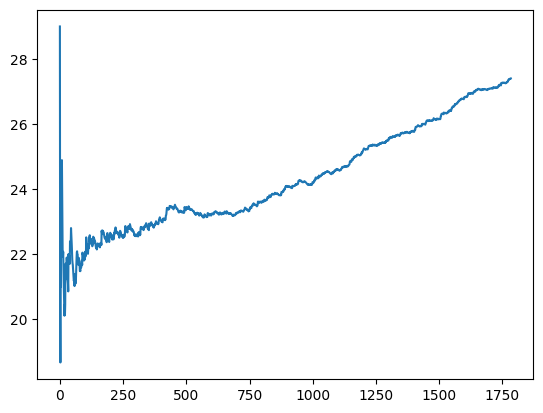

In [80]:
print(f"Total rate of success: {np.mean(h_rwd)}")
plt.plot(np.cumsum(h_rwd) / range(1, len(h_rwd)+1))


KeyboardInterrupt: 

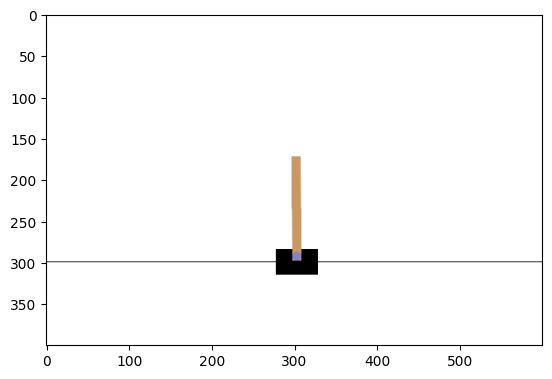

In [81]:

envrender = gym.make('CartPole-v1', render_mode = 'rgb_array')
s,_ = envrender.reset()
traj = [s]
img = plt.imshow(envrender.render()) # only call this once
for i in range(100):
    a = int(torch.argmax(q_network(torch.Tensor(s).unsqueeze(0))))
    s, r, done, trunc, info = envrender.step(a)
    traj.append(s)

    img.set_data(envrender.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done: break

This environment has a state of dimension 4. We plot the value on the positions only, cuting at zero velocities.

Text(0.5, 1.0, 'Q-value landscape (velocity = 0)')

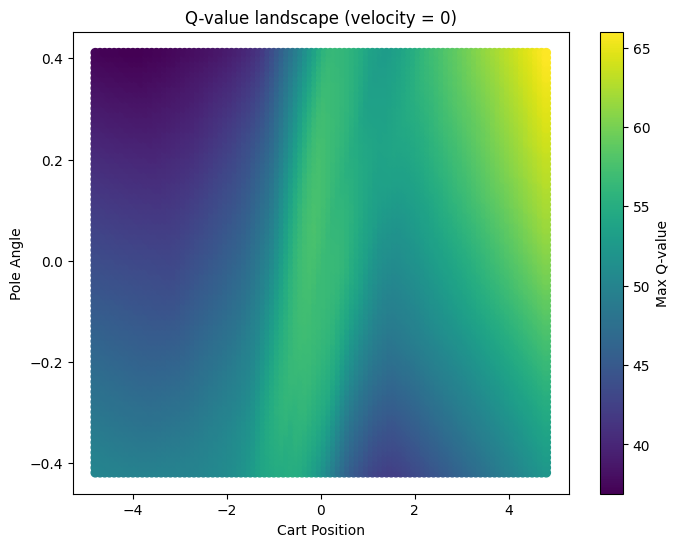

In [82]:

hq = []
hp = []
ha = []
for pos in np.arange(envs.single_observation_space.low[0],
                     envs.single_observation_space.high[0],.1):
    for angle in np.arange(envs.single_observation_space.low[2],
                           envs.single_observation_space.high[2],.01):
        hp.append(pos)
        ha.append(angle)
        hq.append(float(torch.max(
            q_network(torch.tensor([[pos, 0, angle, 0]], dtype=torch.float32)))))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(hp, ha, c=hq)
plt.colorbar(label='Max Q-value')
plt.xlabel('Cart Position')
plt.ylabel('Pole Angle')
plt.title('Q-value landscape (velocity = 0)')


## Deep deterministic policy gradient (DDPG)

Finally, let's consider the case where the actions also are living in a continuous space. In that case, we also need to train a policy network to locally optimize the value (i.e. greedy behavior on the value).

In [87]:

# HYPERPARAM
SEED = 1
ENV_ID = "Pendulum-v1"
NUM_ENVS = 1
LEARNING_RATE = 3e-4
BUFFER_SIZE = int(1e6)
TOTAL_TIMESTEPS = 1000000
TRAIN_FREQUENCY = 2
BATCH_SIZE = 256
GAMMA = 0.99
TARGET_NETWORK_FREQUENCY = 2
TAU = 0.005
EXPLORATION_NOISE = 0.1

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x, u):
        x = torch.cat([x, u], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias


# TRY NOT TO MODIFY: seeding
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# env setup
envs = gym.vector.SyncVectorEnv([make_env(ENV_ID, SEED, 0, False, "TP6")])
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs)
qf1 = QNetwork(envs)
qf1_target = QNetwork(envs)
target_actor = Actor(envs)
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
q_optimizer = torch.optim.Adam(list(qf1.parameters()), lr=LEARNING_RATE)
actor_optimizer = torch.optim.Adam(list(actor.parameters()), lr=LEARNING_RATE)

envs.single_observation_space.dtype = np.float32
rb = ReplayBuffer(
    BUFFER_SIZE,
    envs.single_observation_space,
    envs.single_action_space,
    "cpu",
    handle_timeout_termination=False,
)

# start the game
obs, _ = envs.reset(seed=SEED)
h_rwd = []

for global_step in range(TOTAL_TIMESTEPS):
    # ALGO LOGIC: put action logic here
    if global_step < TOTAL_TIMESTEPS//40:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        with torch.no_grad():
            actions = actor(torch.Tensor(obs))
            actions += torch.normal(0, actor.action_scale * EXPLORATION_NOISE)
            actions = actions.numpy().clip(envs.single_action_space.low,
                                           envs.single_action_space.high)

    # execute the game
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # record rewards for plotting purposes
    for idx, (trunc, done) in enumerate(zip(truncations, terminations)):
        if trunc or done:
            print(f"global_step={global_step}, episodic_return={infos['episode']['r'][idx]}")
            h_rwd.append(infos['episode']['r'][idx])

    # save data to replay buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    # Next lines should be much better but seems broken in this version of Gym. FIXME
    #for idx, trunc in enumerate(truncations):
    #    if trunc:
    #        real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > TOTAL_TIMESTEPS // 40:
        data = rb.sample(BATCH_SIZE)
        with torch.no_grad():
            next_state_actions = target_actor(data.next_observations)
            qf1_next_target = qf1_target(data.next_observations, next_state_actions)
            next_q_value = data.rewards.flatten() \
                + (1 - data.dones.flatten()) * GAMMA * (qf1_next_target).view(-1)

        qf1_a_values = qf1(data.observations, data.actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)

        # optimize the model
        q_optimizer.zero_grad()
        qf1_loss.backward()
        q_optimizer.step()

        if global_step % TRAIN_FREQUENCY == 0:
            actor_loss = -qf1(data.observations, actor(data.observations)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

        # update the target network
        if global_step % TARGET_NETWORK_FREQUENCY == 0:
            for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(TAU * param.data + (1 - TAU) * target_param.data)

envs.close()

global_step=199, episodic_return=-876.4884693994634
global_step=400, episodic_return=-1396.416776241418
global_step=601, episodic_return=-949.6564719126037
global_step=802, episodic_return=-1199.3627080898495
global_step=1003, episodic_return=-849.8427078346961
global_step=1204, episodic_return=-1052.513328821688
global_step=1405, episodic_return=-963.927443051506
global_step=1606, episodic_return=-1148.0928906565518
global_step=1807, episodic_return=-1185.6238487599483
global_step=2008, episodic_return=-1362.0295217456078
global_step=2209, episodic_return=-1055.0111919618703
global_step=2410, episodic_return=-860.7256867943812
global_step=2611, episodic_return=-1651.1894590310899
global_step=2812, episodic_return=-975.6574262069073
global_step=3013, episodic_return=-1303.744534484263
global_step=3214, episodic_return=-881.1655786506705
global_step=3415, episodic_return=-1173.1479414477872
global_step=3616, episodic_return=-1020.8317304989035
global_step=3817, episodic_return=-1653.128

KeyboardInterrupt: 